<a target="_blank" href="https://colab.research.google.com/github/eeg2025/startkit/blob/main/challenge_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [51]:
# Identify whether a CUDA-enabled GPU is available
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    msg ='CUDA-enabled GPU found. Training should be faster.'
else:
    msg = (
        "No GPU found. Training will be carried out on CPU, which might be "
        "slower.\n\nIf running on Google Colab, you can request a GPU runtime by"
        " clicking\n`Runtime/Change runtime type` in the top bar menu, then "
        "selecting \'T4 GPU\'\nunder \'Hardware accelerator\'."
    )
print(msg)

No GPU found. Training will be carried out on CPU, which might be slower.

If running on Google Colab, you can request a GPU runtime by clicking
`Runtime/Change runtime type` in the top bar menu, then selecting 'T4 GPU'
under 'Hardware accelerator'.


In [52]:
from pathlib import Path

data_dir = Path("data")
available_releases = []

if data_dir.exists():
    for item in data_dir.iterdir():
        if item.is_dir() and item.name.startswith("release_"):
            release_num = item.name.split("_")[1]
            available_releases.append(int(release_num))

available_releases.sort()
print(f"Available releases: {available_releases}")

RELEASE_ID = 5 
RELEASE_DIR = Path(f"data/release_{RELEASE_ID}")

if not RELEASE_DIR.exists():
    print(f"Available releases: {available_releases}")
    if available_releases:
        RELEASE_ID = available_releases[0]
        RELEASE_DIR = Path(f"data/release_{RELEASE_ID}")
    else:
        raise FileNotFoundError("No release folders found in data/")

print(f"📁 Loading data from: {RELEASE_DIR.resolve()}")

from eegdash.dataset import EEGChallengeDataset

# Load from the specific release folder
dataset_ccd = EEGChallengeDataset(task="contrastChangeDetection",
                                  release=f"R{RELEASE_ID}", cache_dir=RELEASE_DIR,
                                  mini=False)

print(f"Loaded dataset with {len(dataset_ccd.datasets)} recordings from Release R{RELEASE_ID}")

# Helper function to load different releases for transfer learning
def load_release_data(release_id, task="contrastChangeDetection", mini=False):
    """
    Load data from a specific release folder
    
    Args:
        release_id (int): Release number (1-11)
        task (str): Task name
        mini (bool): Whether to use mini dataset
    
    Returns:
        EEGChallengeDataset: Loaded dataset
    """
    release_dir = Path(f"data/release_{release_id}")
    
    if not release_dir.exists():
        raise FileNotFoundError(f"Release {release_id} folder not found: {release_dir}")
    
    print(f"Loading Release R{release_id} from: {release_dir.resolve()}")
    
    dataset = EEGChallengeDataset(
        task=task,
        release=f"R{release_id}",
        cache_dir=release_dir,
        mini=mini
    )
    
    print(f"Loaded {len(dataset.datasets)} recordings from Release R{release_id}")
    return dataset


Available releases: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
📁 Loading data from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_5


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded dataset with 745 recordings from Release R5


In [53]:
# TRANSFER LEARNING SETUP: Load multiple releases for pre-training and target tasks
print("🔄 Setting up Transfer Learning with Multiple Releases")
print("="*60)

# Option 1: Load source data for pre-training (e.g., releases 1-3)
source_releases = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11]  # Releases to use for pre-training
source_datasets = []

print(f"📚 Loading source releases for pre-training: {source_releases}")
for release_id in source_releases:
    try:
        dataset = load_release_data(release_id, mini=False)
        source_datasets.append(dataset)
        print(f"✅ Added Release R{release_id}: {len(dataset.datasets)} recordings")
    except Exception as e:
        print(f"❌ Failed to load Release R{release_id}: {e}")

# Option 2: Load target data (e.g., release 5)
target_release = 5
print(f"\n🎯 Loading target release: R{target_release}")
try:
    target_dataset = load_release_data(target_release, mini=False)
    print(f"✅ Target dataset ready: {len(target_dataset.datasets)} recordings")
except Exception as e:
    print(f"❌ Failed to load target release: {e}")
    # Use the main dataset as fallback
    target_dataset = dataset_ccd
    print(f"🔄 Using main dataset as target: {len(target_dataset.datasets)} recordings")

# Summary
total_source_recordings = sum(len(dataset.datasets) for dataset in source_datasets)
print(f"\n📊 Transfer Learning Setup Summary:")
print(f"Source releases: {len(source_datasets)} releases, {total_source_recordings} recordings")
print(f"Target release: R{target_release}, {len(target_dataset.datasets)} recordings")
print(f"You can now use source data for pre-training and target data for fine-tuning!")


🔄 Setting up Transfer Learning with Multiple Releases
📚 Loading source releases for pre-training: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11]
Loading Release R1 from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_1


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 293 recordings from Release R1
✅ Added Release R1: 293 recordings
Loading Release R2 from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_2


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 301 recordings from Release R2
✅ Added Release R2: 301 recordings
Loading Release R3 from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_3


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 388 recordings from Release R3
✅ Added Release R3: 388 recordings
Loading Release R4 from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_4


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 756 recordings from Release R4
✅ Added Release R4: 756 recordings
Loading Release R6 from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_6


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 232 recordings from Release R6
✅ Added Release R6: 232 recordings
Loading Release R7 from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_7


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 529 recordings from Release R7
✅ Added Release R7: 529 recordings
Loading Release R8 from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_8


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 512 recordings from Release R8
✅ Added Release R8: 512 recordings
Loading Release R9 from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_9


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 655 recordings from Release R9
✅ Added Release R9: 655 recordings
Loading Release R10 from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_10


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 212 recordings from Release R10
✅ Added Release R10: 212 recordings
Loading Release R11 from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_11


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 767 recordings from Release R11
✅ Added Release R11: 767 recordings

🎯 Loading target release: R5
Loading Release R5 from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_5


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 745 recordings from Release R5
✅ Target dataset ready: 745 recordings

📊 Transfer Learning Setup Summary:
Source releases: 10 releases, 4645 recordings
Target release: R5, 745 recordings
You can now use source data for pre-training and target data for fine-tuning!


In [54]:
print("Testing Data Loading")
print("="*40)
print(f"Main dataset (R{RELEASE_ID}):")
print(f"Location: {RELEASE_DIR.resolve()}")
print(f"Recordings: {len(dataset_ccd.datasets)}")

if len(dataset_ccd.datasets) > 0:
    raw = dataset_ccd.datasets[0].raw
    print(f"   🔬 First recording:")
    print(f"      - Channels: {len(raw.ch_names)}")
    print(f"      - Duration: {raw.times[-1]:.1f}s")
    print(f"      - Sampling rate: {raw.info['sfreq']} Hz")
    print(f"      - Channel names: {raw.ch_names[:5]}...")  # First 5 channels

# Test loading a different release
print(f"\n🔄 Testing loading different release...")
try:
    test_release = 1 if RELEASE_ID != 1 else 2  # Test with a different release
    test_dataset = load_release_data(test_release, mini=False)
    print(f"✅ Successfully loaded Release R{test_release}: {len(test_dataset.datasets)} recordings")
except Exception as e:
    print(f"Failed to load test release: {e}")

print(f"\n🎉 Data loading test complete!")
print(f"💡 Your notebook is now ready to work with your downloaded data structure!")


Testing Data Loading
Main dataset (R5):
Location: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_5
Recordings: 745
   🔬 First recording:
      - Channels: 129
      - Duration: 197.0s
      - Sampling rate: 100.0 Hz
      - Channel names: ['E1', 'E2', 'E3', 'E4', 'E5']...

🔄 Testing loading different release...
Loading Release R1 from: /Users/kimberly/Documents/ESE5380/eeg_challenge/data/release_1


/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 293 recordings from Release R1
✅ Successfully loaded Release R1: 293 recordings

🎉 Data loading test complete!
💡 Your notebook is now ready to work with your downloaded data structure!


In [55]:
#@title ▶️ Install additional required packages for colab
!pip install braindecode
!pip install eegdash

In [56]:
# For visualization purposes, we will see just one object.

raw = dataset_ccd.datasets[0].raw  # get the Raw object of the first recording

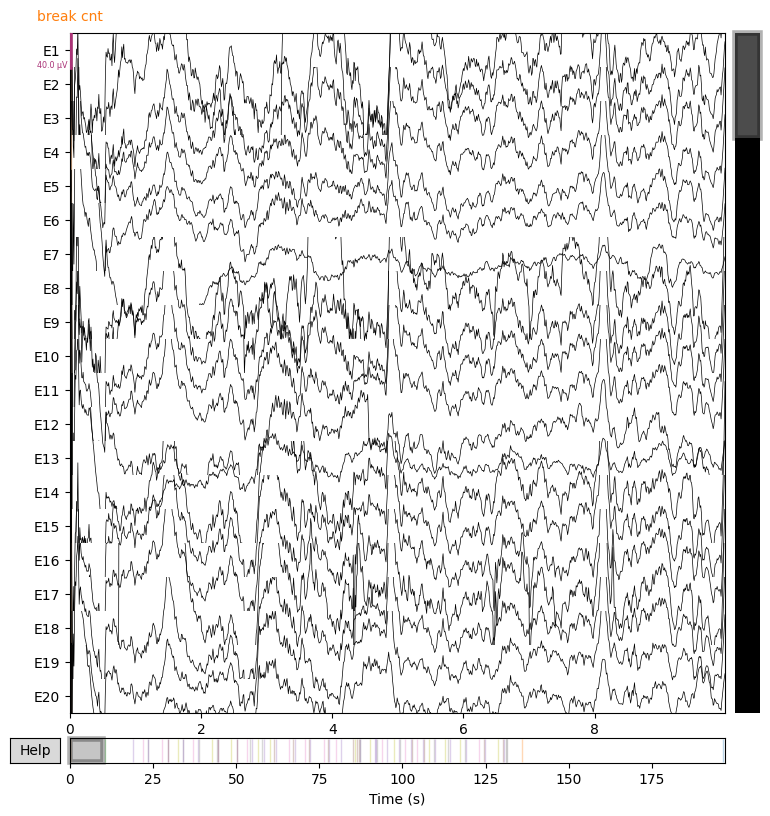

In [57]:
fig = raw.plot()

As you just realized, the eeg dash dataset object will download the dataset only when necessary, and in this case, only when we want to consume the raw data. To download all data directly, we recommend downloading the versions with Amazon API, or doing something like:

In [58]:
from joblib import Parallel, delayed

raws = Parallel(n_jobs=-1)(
    delayed(lambda d: d.raw)(d) for d in dataset_ccd.datasets
)

In [59]:
from braindecode.datasets import BaseConcatDataset

In [60]:
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from eegdash.hbn.windows import (
    annotate_trials_with_target,
    add_aux_anchors,
    add_extras_columns,
    keep_only_recordings_with,
)

EPOCH_LEN_S = 2.0
SFREQ = 100 # by definition here

transformation_offline = [
    Preprocessor(
        annotate_trials_with_target,
        target_field="rt_from_stimulus", epoch_length=EPOCH_LEN_S,
        require_stimulus=True, require_response=True,
        apply_on_array=False,
    ),
    Preprocessor(add_aux_anchors, apply_on_array=False),
]
preprocess(dataset_ccd, transformation_offline, n_jobs=1)

ANCHOR = "stimulus_anchor"

SHIFT_AFTER_STIM = 0.5
WINDOW_LEN       = 2.0

# Keep only recordings that actually contain stimulus anchors
dataset = keep_only_recordings_with(ANCHOR, dataset_ccd)

# Create single-interval windows (stim-locked, long enough to include the response)
single_windows = create_windows_from_events(
    dataset,
    mapping={ANCHOR: 0},
    trial_start_offset_samples=int(SHIFT_AFTER_STIM * SFREQ),                 # +0.5 s
    trial_stop_offset_samples=int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),   # +2.5 s
    window_size_samples=int(EPOCH_LEN_S * SFREQ),
    window_stride_samples=SFREQ,
    preload=True,
)

# Injecting metadata into the extra mne annotation.
single_windows = add_extras_columns(
    single_windows,
    dataset,
    desc=ANCHOR,
    keys=("target", "rt_from_stimulus", "rt_from_trialstart",
          "stimulus_onset", "response_onset", "correct", "response_type")
          )

Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_(

In [61]:
# for each windows, we can extract the metainformation using:
meta_information = single_windows.get_metadata()

In [62]:
meta_information.head()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,rt_from_stimulus,rt_from_trialstart,stimulus_onset,response_onset,correct,response_type,...,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch
0,0,2241,2441,1.486,1.486,4.484,21.906,23.392,0,right_buttonPress,...,available,available,available,available,available,available,available,available,unavailable,caution
1,0,3284,3484,1.562,1.562,4.57,32.34,33.902,1,right_buttonPress,...,available,available,available,available,available,available,available,available,unavailable,caution
2,0,4322,4522,1.51,1.51,5.606,42.724,44.234,1,right_buttonPress,...,available,available,available,available,available,available,available,available,unavailable,caution
3,0,5360,5560,0.97,0.97,3.972,53.096,54.066,0,right_buttonPress,...,available,available,available,available,available,available,available,available,unavailable,caution
4,0,5714,5914,1.172,1.172,3.07,56.644,57.816,1,right_buttonPress,...,available,available,available,available,available,available,available,available,unavailable,caution


## You can inspect your target label doing:

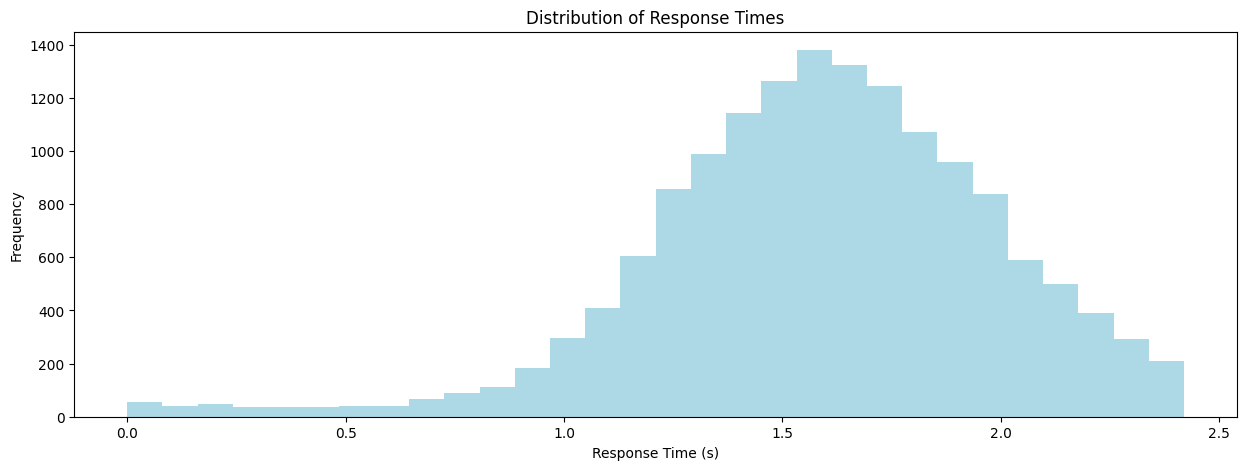

In [63]:
from matplotlib.pylab import plt

fig, ax = plt.subplots(figsize=(15, 5))
ax = meta_information["target"].plot.hist(bins=30, ax=ax, color='lightblue')
ax.set_xlabel("Response Time (s)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Response Times")
plt.show()


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

valid_frac = 0.1
test_frac = 0.1
seed = 2025

subjects = meta_information["subject"].unique()
sub_rm = ["NDARWV769JM7", "NDARME789TD2", "NDARUA442ZVF", "NDARJP304NK1",
          "NDARTY128YLU", "NDARDW550GU6", "NDARLD243KRE", "NDARUJ292JXV", "NDARBA381JGH"]
subjects = [s for s in subjects if s not in sub_rm]

train_subj, valid_test_subject = train_test_split(
    subjects, test_size=(valid_frac + test_frac), random_state=check_random_state(seed), shuffle=True
)

valid_subj, test_subj = train_test_split(
    valid_test_subject, test_size=test_frac, random_state=check_random_state(seed + 1), shuffle=True
)
# sanity check
assert (set(valid_subj) | set(test_subj) | set(train_subj)) == set(subjects)

In [65]:
# and finally using braindecode split function, we can do:
subject_split = single_windows.split("subject")

train_set = []
valid_set = []
test_set = []

for s in subject_split:
    if s in train_subj:
        train_set.append(subject_split[s])
    elif s in valid_subj:
        valid_set.append(subject_split[s])
    elif s in test_subj:
        test_set.append(subject_split[s])

train_set = BaseConcatDataset(train_set)
valid_set = BaseConcatDataset(valid_set)
test_set = BaseConcatDataset(test_set)

print("Number of examples in each split in the minirelease")
print(f"Train:\t{len(train_set)}")
print(f"Valid:\t{len(valid_set)}")
print(f"Test:\t{len(test_set)}")

Number of examples in each split in the minirelease
Train:	12100
Valid:	2714
Test:	330


Finally, we create pytorch `DataLoader`s, which will be used to feed the data to the model during training and evaluation:

In [66]:
# Create datasets and dataloaders
from torch.utils.data import DataLoader

batch_size = 128
num_workers = 1 # We are using a single worker, but you can increase this for faster data loading

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [67]:
# from braindecode.models.util import models_dict

# names = sorted(models_dict)
# w = max(len(n) for n in names)

# for i in range(0, len(names), 3):
#     row = names[i:i+3]
#     print("  ".join(f"{n:<{w}}" for n in row))

In [68]:
# Defining training parameters
lr = 1E-3
weight_decay = 1E-5
n_epochs = 100
early_stopping_patience = 50

In [69]:
from typing import Optional
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn import Module
from torch.optim.lr_scheduler import LRScheduler
# Define a method for training one epoch
def train_one_epoch(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    optimizer,
    scheduler: Optional[LRScheduler],
    epoch: int,
    device,
    print_batch_stats: bool = True,
):
    model.train()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_samples = 0

    progress_bar = tqdm(
        enumerate(dataloader), total=len(dataloader), disable=not print_batch_stats
    )

    for batch_idx, batch in progress_bar:
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()

        optimizer.zero_grad(set_to_none=True)
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Flatten to 1D for regression metrics and accumulate squared error
        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            progress_bar.set_description(
                f"Epoch {epoch}, Batch {batch_idx + 1}/{len(dataloader)}, "
                f"Loss: {loss.item():.6f}, RMSE: {running_rmse:.6f}"
            )

    if scheduler is not None:
        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
    return avg_loss, rmse

In [70]:
import torch
from torch.utils.data import DataLoader
from torch.nn import Module
from tqdm import tqdm

@torch.no_grad()
def valid_model(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    device,
    print_batch_stats: bool = True,
):
    model.eval()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_batches = len(dataloader)
    n_samples = 0

    iterator = tqdm(
        enumerate(dataloader),
        total=n_batches,
        disable=not print_batch_stats
    )

    for batch_idx, batch in iterator:
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()
        # casting X to float32

        preds = model(X)
        batch_loss = loss_fn(preds, y).item()
        total_loss += batch_loss

        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            iterator.set_description(
                f"Val Batch {batch_idx + 1}/{n_batches}, "
                f"Loss: {batch_loss:.6f}, RMSE: {running_rmse:.6f}"
            )

    avg_loss = total_loss / n_batches if n_batches else float("nan")
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5

    print(f"Val RMSE: {rmse:.6f}, Val Loss: {avg_loss:.6f}\n")
    return avg_loss, rmse

In [71]:
from braindecode.models import EEGMiner

model1 = EEGMiner(n_chans=129, # 129 channels
                n_outputs=1, # 1 output for regression
                n_times=200, #2 seconds
                sfreq=100,      # sample frequency 100 Hz
                )

print(model1)

Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
EEGMiner (EEGMiner)                           [1, 129, 200]             [1, 1]                    --                        --
├─Rearrange (ensure_dim): 1-1                 [1, 129, 200]             [1, 129, 1, 200]          --                        --
├─GeneralizedGaussianFilter (filter): 1-2     [1, 129, 1, 200]          [1, 129, 2, 101, 2]       109                       --
├─BatchNorm1d (batch_layer): 1-3              [1, 16512]                [1, 16512]                --                        --
├─Linear (final_layer): 1-4                   [1, 16512]                [1, 1]                    16,513                    --
Total params: 16,622
Trainable params: 16,519
Non-trainable params: 103
Total mult-adds (Units.MEGABYTES): 0.02
Input size (MB): 0.10
Forward/backward pass size (MB): 0.42
Params size (MB): 0.07
Estimated Total Size (MB): 0.59


In [72]:
from braindecode.models import EEGConformer
model2 = EEGConformer(n_chans=129, # 129 channels
                n_outputs=1, # 1 output for regression
                n_times=200, #2 seconds
                sfreq=100,      # sample frequency 100 Hz
                )

print(model2)

Layer (type (var_name):depth-idx)                                      Input Shape               Output Shape              Param #                   Kernel Shape
EEGConformer (EEGConformer)                                            [1, 129, 200]             [1, 1]                    --                        --
├─_PatchEmbedding (patch_embedding): 1-1                               [1, 1, 129, 200]          [1, 7, 40]                --                        --
│    └─Sequential (shallownet): 2-1                                    [1, 1, 129, 200]          [1, 40, 1, 7]             --                        --
│    │    └─Conv2d (0): 3-1                                            [1, 1, 129, 200]          [1, 40, 129, 176]         1,040                     [1, 25]
│    │    └─Conv2d (1): 3-2                                            [1, 40, 129, 176]         [1, 40, 1, 176]           206,440                   [129, 1]
│    │    └─BatchNorm2d (2): 3-3                                   

/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/braindecode/models/eegconformer.py:227: UserWarning: This model has only been tested on no more than 64 channels. no guarantee to work with more channels.
  warnings.warn(


In [78]:
# Feature extraction with caching - checks for cached features first
from pathlib import Path
from datetime import datetime

# Define cache directory and filenames
cache_dir = Path("eeg_cache")
cache_dir.mkdir(exist_ok=True)

# Use release ID and window count to create unique cache filenames
cache_key = f"R{RELEASE_ID}_n{len(single_windows)}_sfreq{SFREQ}"
X_cache_file = cache_dir / f"X_all_{cache_key}.npy"
y_cache_file = cache_dir / f"y_all_{cache_key}.npy"
subj_cache_file = cache_dir / f"subj_all_{cache_key}.npy"
cache_info_file = cache_dir / f"cache_info_{cache_key}.txt"

# Check if cached features exist
if all(f.exists() for f in [X_cache_file, y_cache_file, subj_cache_file]):
    print(f"📦 Loading cached features from {cache_dir}...")
    print(f"   Cache key: {cache_key}")
    
    X_all = np.load(X_cache_file)
    y_all = np.load(y_cache_file)
    subj_all = np.load(subj_cache_file)
    
    # Load cache info if available
    if cache_info_file.exists():
        with open(cache_info_file, 'r') as f:
            info = f.read().strip()
            print(f"   {info}")
    
    print(f"✅ Loaded cached features!")
    print(f"   X_all shape: {X_all.shape}")
    print(f"   y_all shape: {y_all.shape}")
    print(f"   Number of unique subjects: {len(np.unique(subj_all))}")
    print(f"   Feature vector length per window: {X_all.shape[1]}")
else:
    print(f"🔄 No cached features found. Run the feature extraction cell below.")
    print(f"   Cache key will be: {cache_key}")


🔄 No cached features found. Run the feature extraction cell below.
   Cache key will be: R5_n15144_sfreq100


In [73]:
import numpy as np

In [75]:
import numpy as np
import scipy.signal as sig
from scipy.stats import skew, kurtosis

def bandpower(data, fs, fmin, fmax):
    f, Pxx = sig.welch(data, fs=fs, nperseg=min(256, len(data)), nfft=1024)
    band = (f >= fmin) & (f <= fmax)
    return np.trapz(Pxx[band], f[band])

def extract_features_from_window(window_np: np.ndarray, fs: float = 200.0) -> np.ndarray:
    """
    Extract statistical + spectral features from EEG window.
    window_np shape: (n_chans, n_times)
    """
    # Basic stats
    means = window_np.mean(axis=1)
    stds = window_np.std(axis=1) + 1e-8
    skews = skew(window_np, axis=1, bias=False, nan_policy='omit')
    kurts = kurtosis(window_np, axis=1, fisher=True, bias=False, nan_policy='omit')

    # Define canonical EEG bands
    bands = {
        "delta": (1, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "beta": (13, 30),
        "gamma": (30, 50)
    }

    # Compute bandpower for each channel
    band_feats = []
    for ch in range(window_np.shape[0]):
        ch_data = window_np[ch, :]
        ch_bandpowers = [bandpower(ch_data, fs, fmin, fmax) for fmin, fmax in bands.values()]
        band_feats.append(ch_bandpowers)
    band_feats = np.array(band_feats)  # shape: (n_chans, n_bands)

    # Combine all features
    feats = np.concatenate([
        means[:, None],
        stds[:, None],
        skews[:, None],
        kurts[:, None],
        band_feats
    ], axis=1).reshape(-1)

    feats = np.nan_to_num(feats, nan=0.0, posinf=0.0, neginf=0.0)
    return feats

In [76]:
# Extract features from all windows using extract_features_from_window
from tqdm import tqdm
import torch

# Get metadata for targets and subjects
meta_info = single_windows.get_metadata()

# Initialize lists to store features, targets, and subjects
X_list = []
y_list = []
subj_list = []

print(f"Extracting features from {len(single_windows)} windows...")
print(f"Sampling rate: {SFREQ} Hz")

# Iterate through all windows and extract features
for idx in tqdm(range(len(single_windows)), desc="Extracting features"):
    # Get window data - braindecode windows return (X, y, metadata) tuple
    # where X is the EEG data, y is the label, and metadata contains additional info
    window_tuple = single_windows[idx]
    
    # Extract EEG data (X is the first element of the tuple)
    # Need to handle both torch tensors and numpy arrays
    if isinstance(window_tuple, tuple):
        window_data = window_tuple[0]  # Get the EEG data (first element)
    else:
        window_data = window_tuple  # If not a tuple, it's the data directly
    
    # Convert to numpy array - handle both torch tensors and numpy arrays
    if isinstance(window_data, torch.Tensor):
        window_np = window_data.numpy()  # Convert torch tensor to numpy
    elif isinstance(window_data, np.ndarray):
        window_np = window_data  # Already a numpy array
    else:
        print(f"Warning: Window {idx} has unexpected type: {type(window_data)}, skipping")
        continue
    
    # If the window has extra dimensions, squeeze them
    # Window might be (1, n_chans, n_times) or (n_chans, n_times)
    while window_np.ndim > 2:
        window_np = window_np.squeeze(0)
    
    # Ensure shape is (n_chans, n_times) - required by extract_features_from_window
    if window_np.ndim != 2:
        print(f"Warning: Window {idx} has unexpected shape: {window_np.shape}, skipping")
        continue
    
    # Extract features using the function (use SFREQ which is 100 Hz)
    # This is where we actually call your extract_features_from_window function!
    features = extract_features_from_window(window_np, fs=SFREQ)
    X_list.append(features)
    
    # Get target (response time) from metadata
    target = meta_info.iloc[idx]['target']
    y_list.append(target)
    
    # Get subject ID from metadata
    subject = meta_info.iloc[idx]['subject']
    subj_list.append(subject)

# Convert to numpy arrays
X_all = np.array(X_list)
y_all = np.array(y_list)
subj_all = np.array(subj_list)

print(f"\nFeature extraction complete!")
print(f"X_all shape: {X_all.shape}")
print(f"y_all shape: {y_all.shape}")
print(f"Number of unique subjects: {len(np.unique(subj_all))}")
print(f"Feature vector length per window: {X_all.shape[1]}")


Extracting features from 15144 windows...
Sampling rate: 100 Hz


Extracting features:   0%|          | 0/15144 [00:00<?, ?it/s]/var/folders/fq/t46mbxyj54j1d9t60j44v_j80000gn/T/ipykernel_13937/569268286.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skews = skew(window_np, axis=1, bias=False, nan_policy='omit')
/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/python3.13/site-packages/scipy/stats/_stats_py.py:1361: RuntimeWarning: invalid value encountered in divide
  nval = ((n - 1.0) * n)**0.5 / (n - 2.0) * m3 / m2**1.5
/var/folders/fq/t46mbxyj54j1d9t60j44v_j80000gn/T/ipykernel_13937/569268286.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurts = kurtosis(window_np, axis=1, fisher=True, bias=False, nan_policy='omit')
/Users/kimberly/Documents/ESE5380/eeg_challenge/eeg_env/lib/


Feature extraction complete!
X_all shape: (15144, 1161)
y_all shape: (15144,)
Number of unique subjects: 260
Feature vector length per window: 1161


In [79]:
# Save extracted features to cache (run this after feature extraction completes)
# This will save the features so they don't need to be re-extracted next time

# Check if features exist (from previous cell)
if 'X_all' in globals() and 'y_all' in globals() and 'subj_all' in globals():
    print(f"💾 Saving features to cache...")
    
    # Save arrays
    np.save(X_cache_file, X_all)
    np.save(y_cache_file, y_all)
    np.save(subj_cache_file, subj_all)
    
    # Save cache info
    cache_info = f"Cached on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
    cache_info += f"Release: R{RELEASE_ID}\n"
    cache_info += f"Windows: {len(single_windows)}\n"
    cache_info += f"Sampling rate: {SFREQ} Hz\n"
    cache_info += f"X_all shape: {X_all.shape}\n"
    cache_info += f"y_all shape: {y_all.shape}\n"
    cache_info += f"Feature vector length: {X_all.shape[1]}\n"
    
    with open(cache_info_file, 'w') as f:
        f.write(cache_info)
    
    print(f"   ✅ Saved to: {cache_dir}/")
    print(f"      - {X_cache_file.name}")
    print(f"      - {y_cache_file.name}")
    print(f"      - {subj_cache_file.name}")
    print(f"      - {cache_info_file.name}")
    print(f"\n   Next time you run the cache check cell, features will load automatically!")
else:
    print("⚠️  Features not found. Run the feature extraction cell first.")


💾 Saving features to cache...
   ✅ Saved to: eeg_cache/
      - X_all_R5_n15144_sfreq100.npy
      - y_all_R5_n15144_sfreq100.npy
      - subj_all_R5_n15144_sfreq100.npy
      - cache_info_R5_n15144_sfreq100.txt

   Next time you run the cache check cell, features will load automatically!


In [80]:
# Split by subject and scale features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Subject-level split (80/20)
uniq_subj = np.unique(subj_all)
train_subj, test_subj = train_test_split(uniq_subj, test_size=0.2, random_state=42, shuffle=True)

train_mask = np.isin(subj_all, train_subj)
test_mask  = np.isin(subj_all, test_subj)

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print(f"Train: X={X_train_scaled.shape}, Test: X={X_test_scaled.shape}")

Train: X=(12249, 1161), Test: X=(2895, 1161)


In [ ]:
!pip install --upgrade pip
!pip install xgboost

In [86]:
# Add feature names to the top features
# Map feature indices to actual feature names (channel + feature type)

features_per_channel = 9
feature_names_per_channel = ['mean', 'std', 'skewness', 'kurtosis', 
                              'delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power']

def get_feature_name(feat_idx):
    """Convert feature index to human-readable name"""
    channel_idx = feat_idx // features_per_channel
    feature_type_idx = feat_idx % features_per_channel
    feature_type = feature_names_per_channel[feature_type_idx]
    return f"Ch{channel_idx:03d}_{feature_type}"

# Add feature names if not already added
if 'Feature_Name' not in feature_df.columns:
    feature_df['Feature_Name'] = feature_df.index.map(lambda x: get_feature_name(int(x)))

print(f"\n🏆 Top 20 Most Important Features (with Labels):")
print("=" * 120)
print(f"{'Rank':<6} {'ID':<8} {'Feature_Name':<30} {'Channel':<10} {'Type':<15} {'RF':<10} {'XGB':<10} {'Lasso':<10} {'Avg':<10}")
print("-" * 120)

for rank, (feat_idx, row) in enumerate(feature_df.head(20).iterrows(), 1):
    feat_id = int(feat_idx)
    feat_name = row['Feature_Name']
    # Parse channel and type from name
    parts = feat_name.split('_')
    channel = parts[0]
    feat_type = '_'.join(parts[1:])
    
    rf_imp = f"{row['RandomForest']:.4f}"
    xgb_imp = f"{row['XGBoost']:.4f}" if xgb_importances is not None else "N/A"
    lasso_imp = f"{row['Lasso']:.4f}"
    avg_imp = f"{row['Avg_Importance']:.4f}"
    
    print(f"{rank:<6} {feat_id:<8} {feat_name:<30} {channel:<10} {feat_type:<15} {rf_imp:<10} {xgb_imp:<10} {lasso_imp:<10} {avg_imp:<10}")

print("=" * 120)
print("\n💡 Feature Type Explanation:")
print("   - mean: Average amplitude of the signal")
print("   - std: Standard deviation (variability)")
print("   - skewness: Asymmetry of the distribution")
print("   - kurtosis: Tail heaviness of the distribution")
print("   - delta_power: Power in 1-4 Hz band")
print("   - theta_power: Power in 4-8 Hz band")
print("   - alpha_power: Power in 8-13 Hz band")
print("   - beta_power: Power in 13-30 Hz band")
print("   - gamma_power: Power in 30-50 Hz band")



🏆 Top 20 Most Important Features (with Labels):
Rank   ID       Feature_Name                   Channel    Type            RF         XGB        Lasso      Avg       
------------------------------------------------------------------------------------------------------------------------
1      932      Ch103_theta_power              Ch103      theta_power     1.0000     1.0000     0.0000     0.6667    
2      1043     Ch115_gamma_power              Ch115      gamma_power     0.9118     0.5722     0.0000     0.4947    
3      599      Ch066_theta_power              Ch066      theta_power     0.4307     0.5645     0.3776     0.4576    
4      300      Ch033_kurtosis                 Ch033      kurtosis        0.1624     0.1750     1.0000     0.4458    
5      602      Ch066_gamma_power              Ch066      gamma_power     0.6070     0.7000     0.0000     0.4356    
6      669      Ch074_kurtosis                 Ch074      kurtosis        0.2852     0.1909     0.7918     0.4226    
7   

In [81]:
# Train multiple regressors and report RMSE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

try:
    from xgboost import XGBRegressor
    _has_xgb = True
except Exception:
    _has_xgb = False

models = {
    'LinearRegression': LinearRegression(),
    'Ridge(alpha=1.0)': Ridge(alpha=1.0, random_state=42),
    'Lasso(alpha=1e-3)': Lasso(alpha=1e-3, random_state=42, max_iter=5000),
    'RandomForest(200)': RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
}

if _has_xgb:
    models['XGBRegressor'] = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42,
        tree_method='hist'
    )
else:
    print("XGBoost not available. Skipping XGBRegressor.")

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
    results.append((name, rmse))
    print(f"{name}: Test RMSE = {rmse:.6f}")

# Sort and display best
results_sorted = sorted(results, key=lambda x: x[1])
print("\nTop models (lower RMSE is better):")
for rank, (name, rmse) in enumerate(results_sorted, 1):
    print(f"{rank:2d}. {name:22s} RMSE={rmse:.6f}")


LinearRegression: Test RMSE = 11.904708
Ridge(alpha=1.0): Test RMSE = 0.578220
Lasso(alpha=1e-3): Test RMSE = 0.403739
RandomForest(200): Test RMSE = 0.398454
XGBRegressor: Test RMSE = 0.401855

Top models (lower RMSE is better):
 1. RandomForest(200)      RMSE=0.398454
 2. XGBRegressor           RMSE=0.401855
 3. Lasso(alpha=1e-3)      RMSE=0.403739
 4. Ridge(alpha=1.0)       RMSE=0.578220
 5. LinearRegression       RMSE=11.904708


In [ ]:
# os.makedirs("linear_models", exist_ok=True)

In [83]:
import os, joblib, datetime, torch
from sklearn.pipeline import Pipeline

os.makedirs("linear_models", exist_ok=True)
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

to_save = [
    "RandomForest(200)",
    "XGBRegressor",
    "Lasso(alpha=1e-3)",
    "LinearRegression",
    "Ridge(alpha=1.0)",
]

saved_paths = []
for name in to_save:
    if name not in models:
        print(f"Skipping {name} (not trained/available).")
        continue

    pipe = Pipeline([("scaler", scaler), ("model", models[name])])

    base = name.replace("(", "_").replace(")", "").replace(" ", "")
    joblib_path = f"linear_models/{base}_{ts}.joblib"
    pt_path     = f"linear_models/{base}_{ts}.pt"

    joblib.dump(pipe, joblib_path)
    torch.save(pipe, pt_path)  # pickle-based

    saved_paths += [joblib_path, pt_path]

print("Saved:")
for p in saved_paths:
    print(" -", p)

Saved:
 - linear_models/RandomForest_200_20251101_170036.joblib
 - linear_models/RandomForest_200_20251101_170036.pt
 - linear_models/XGBRegressor_20251101_170036.joblib
 - linear_models/XGBRegressor_20251101_170036.pt
 - linear_models/Lasso_alpha=1e-3_20251101_170036.joblib
 - linear_models/Lasso_alpha=1e-3_20251101_170036.pt
 - linear_models/LinearRegression_20251101_170036.joblib
 - linear_models/LinearRegression_20251101_170036.pt
 - linear_models/Ridge_alpha=1.0_20251101_170036.joblib
 - linear_models/Ridge_alpha=1.0_20251101_170036.pt


🔍 Feature Selection and Analysis

📊 Feature Importance Summary:
   Total features: 1161
   Lasso selected features (non-zero): 207 (17.8%)

🏆 Top 20 Most Important Features:
      RandomForest   XGBoost     Lasso  Avg_Importance
932       1.000000  1.000000  0.000000        0.666667
1043      0.911795  0.572205  0.000000        0.494667
599       0.430719  0.564528  0.377601        0.457616
300       0.162364  0.174977  1.000000        0.445781
602       0.606993  0.699951  0.000000        0.435648
669       0.285196  0.190898  0.791834        0.422643
561       0.312636  0.131714  0.821377        0.421909
614       0.173068  0.152186  0.852493        0.392582
244       0.369313  0.790972  0.000000        0.386761
928       0.561114  0.531825  0.000000        0.364313
12        0.245268  0.132749  0.670283        0.349433
433       0.329903  0.279312  0.434180        0.347799
1081      0.289269  0.293919  0.448149        0.343779
600       0.339641  0.457698  0.230626        0.342655
9

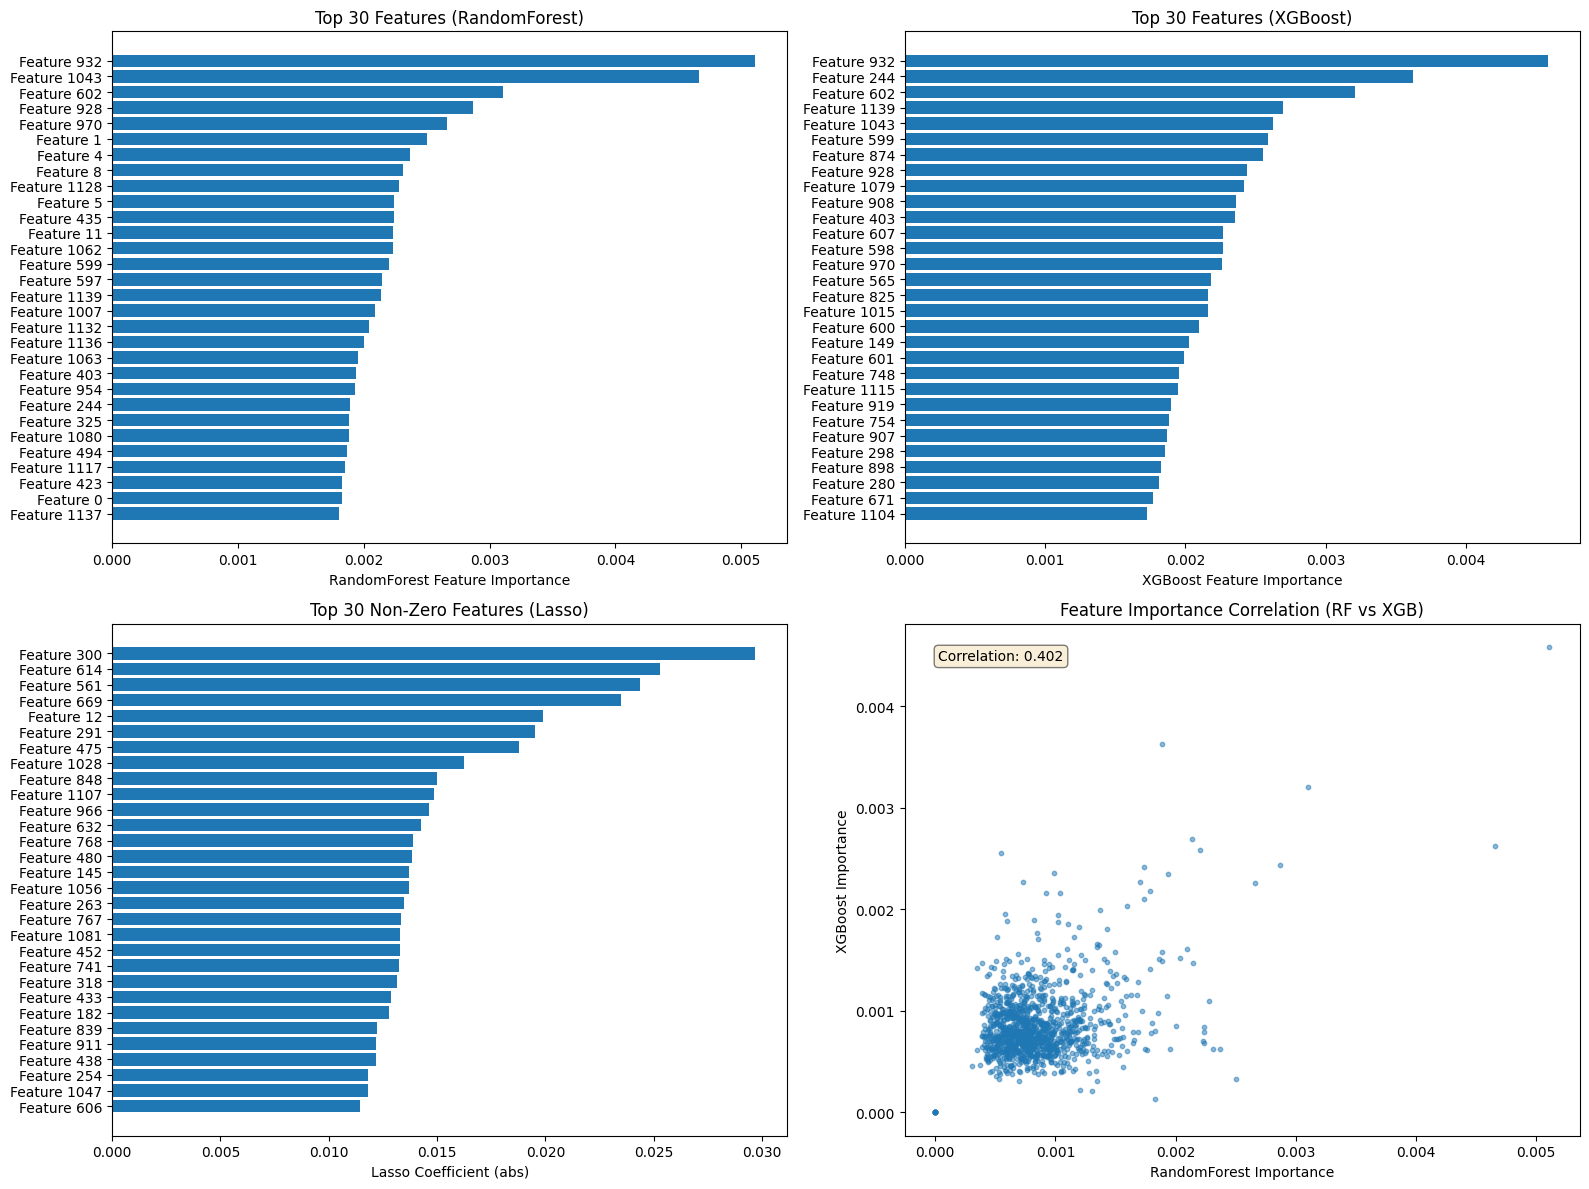


🎯 Feature Selection Options:
   Total features: 1161
   Lasso selected: 207 features (17.8%)
   Top 50 features: indices [932, 1043, 599, 300, 602, 669, 561, 614, 244, 928]... (avg importance > 0.2515)
   Top 100 features: indices [932, 1043, 599, 300, 602, 669, 561, 614, 244, 928]... (avg importance > 0.2067)
   Top 200 features: indices [932, 1043, 599, 300, 602, 669, 561, 614, 244, 928]... (avg importance > 0.1654)
   Top 500 features: indices [932, 1043, 599, 300, 602, 669, 561, 614, 244, 928]... (avg importance > 0.1212)

💾 Saved feature importance data to: feature_importance_analysis.csv


In [84]:
# Feature Selection and Analysis
# Extract feature importance from tree-based models and Lasso coefficients
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("🔍 Feature Selection and Analysis")
print("="*60)

# 1. RandomForest Feature Importance
rf_model = models['RandomForest(200)']
rf_importances = rf_model.feature_importances_

# 2. XGBoost Feature Importance
if 'XGBRegressor' in models:
    xgb_model = models['XGBRegressor']
    xgb_importances = xgb_model.feature_importances_
else:
    xgb_importances = None

# 3. Lasso Coefficients (absolute values = importance)
lasso_model = models['Lasso(alpha=1e-3)']
lasso_coef = np.abs(lasso_model.coef_)
lasso_nonzero = np.sum(lasso_coef > 1e-6)  # Count non-zero features

print(f"\n📊 Feature Importance Summary:")
print(f"   Total features: {len(rf_importances)}")
print(f"   Lasso selected features (non-zero): {lasso_nonzero} ({100*lasso_nonzero/len(rf_importances):.1f}%)")

# Create DataFrame for easy analysis
feature_df = pd.DataFrame({
    'RandomForest': rf_importances,
    'XGBoost': xgb_importances if xgb_importances is not None else np.zeros(len(rf_importances)),
    'Lasso': lasso_coef
})

# Normalize importances to 0-1 scale for comparison
for col in feature_df.columns:
    if feature_df[col].max() > 0:
        feature_df[col] = feature_df[col] / feature_df[col].max()

# Rank features by average importance
feature_df['Avg_Importance'] = feature_df.mean(axis=1)
feature_df = feature_df.sort_values('Avg_Importance', ascending=False)

print(f"\n🏆 Top 20 Most Important Features:")
print(feature_df.head(20)[['RandomForest', 'XGBoost', 'Lasso', 'Avg_Importance']])

# Visualize top features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top 30 features by RandomForest
top_n = 30
top_rf_indices = np.argsort(rf_importances)[-top_n:][::-1]
axes[0, 0].barh(range(top_n), rf_importances[top_rf_indices])
axes[0, 0].set_yticks(range(top_n))
axes[0, 0].set_yticklabels([f'Feature {i}' for i in top_rf_indices])
axes[0, 0].set_xlabel('RandomForest Feature Importance')
axes[0, 0].set_title(f'Top {top_n} Features (RandomForest)')
axes[0, 0].invert_yaxis()

# Plot 2: Top 30 features by XGBoost
if xgb_importances is not None:
    top_xgb_indices = np.argsort(xgb_importances)[-top_n:][::-1]
    axes[0, 1].barh(range(top_n), xgb_importances[top_xgb_indices])
    axes[0, 1].set_yticks(range(top_n))
    axes[0, 1].set_yticklabels([f'Feature {i}' for i in top_xgb_indices])
    axes[0, 1].set_xlabel('XGBoost Feature Importance')
    axes[0, 1].set_title(f'Top {top_n} Features (XGBoost)')
    axes[0, 1].invert_yaxis()
else:
    axes[0, 1].text(0.5, 0.5, 'XGBoost not available', ha='center', va='center')
    axes[0, 1].set_title('XGBoost Feature Importance')

# Plot 3: Lasso coefficients (non-zero only)
non_zero_lasso = lasso_coef[lasso_coef > 1e-6]
if len(non_zero_lasso) > 0:
    top_lasso_indices = np.argsort(lasso_coef)[-min(top_n, len(non_zero_lasso)):][::-1]
    top_lasso_indices = top_lasso_indices[lasso_coef[top_lasso_indices] > 1e-6]
    if len(top_lasso_indices) > 0:
        axes[1, 0].barh(range(len(top_lasso_indices)), lasso_coef[top_lasso_indices])
        axes[1, 0].set_yticks(range(len(top_lasso_indices)))
        axes[1, 0].set_yticklabels([f'Feature {i}' for i in top_lasso_indices])
        axes[1, 0].set_xlabel('Lasso Coefficient (abs)')
        axes[1, 0].set_title(f'Top {len(top_lasso_indices)} Non-Zero Features (Lasso)')
        axes[1, 0].invert_yaxis()
    else:
        axes[1, 0].text(0.5, 0.5, 'No significant features', ha='center', va='center')
else:
    axes[1, 0].text(0.5, 0.5, 'No non-zero features', ha='center', va='center')

# Plot 4: Feature importance correlation
if xgb_importances is not None:
    axes[1, 1].scatter(rf_importances, xgb_importances, alpha=0.5, s=10)
    axes[1, 1].set_xlabel('RandomForest Importance')
    axes[1, 1].set_ylabel('XGBoost Importance')
    axes[1, 1].set_title('Feature Importance Correlation (RF vs XGB)')
    
    # Calculate correlation
    corr = np.corrcoef(rf_importances, xgb_importances)[0, 1]
    axes[1, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                    transform=axes[1, 1].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    axes[1, 1].text(0.5, 0.5, 'XGBoost not available', ha='center', va='center')

plt.tight_layout()
plt.savefig('feature_importance_analysis.png', dpi=150, bbox_inches='tight')
print(f"\n💾 Saved visualization to: feature_importance_analysis.png")
plt.show()

# Feature selection: Select top N features based on average importance
print(f"\n🎯 Feature Selection Options:")
print(f"   Total features: {len(rf_importances)}")
print(f"   Lasso selected: {lasso_nonzero} features ({100*lasso_nonzero/len(rf_importances):.1f}%)")

# Suggest top K features based on average importance
for k in [50, 100, 200, 500]:
    top_k_indices = feature_df.head(k).index.values
    print(f"   Top {k} features: indices {top_k_indices[:10].tolist()}... (avg importance > {feature_df.iloc[k-1]['Avg_Importance']:.4f})")

# Save feature importance data
feature_df.to_csv('feature_importance_analysis.csv')
print(f"\n💾 Saved feature importance data to: feature_importance_analysis.csv")


🔄 Retraining with Selected Features

📊 50 Features Selected:
   RandomForest RMSE: 0.398521 (vs 0.398454 with all features)
   XGBoost RMSE: 0.401923 (vs 0.401855 with all features)

📊 100 Features Selected:
   RandomForest RMSE: 0.399390 (vs 0.398454 with all features)
   XGBoost RMSE: 0.404019 (vs 0.401855 with all features)

📊 200 Features Selected:
   RandomForest RMSE: 0.397146 (vs 0.398454 with all features)
   XGBoost RMSE: 0.404611 (vs 0.401855 with all features)

📊 500 Features Selected:
   RandomForest RMSE: 0.397257 (vs 0.398454 with all features)
   XGBoost RMSE: 0.401725 (vs 0.401855 with all features)

📊 207 Features Selected:
   RandomForest RMSE: 0.396711 (vs 0.398454 with all features)
   XGBoost RMSE: 0.402970 (vs 0.401855 with all features)

💾 Saved performance comparison to: feature_selection_performance.png


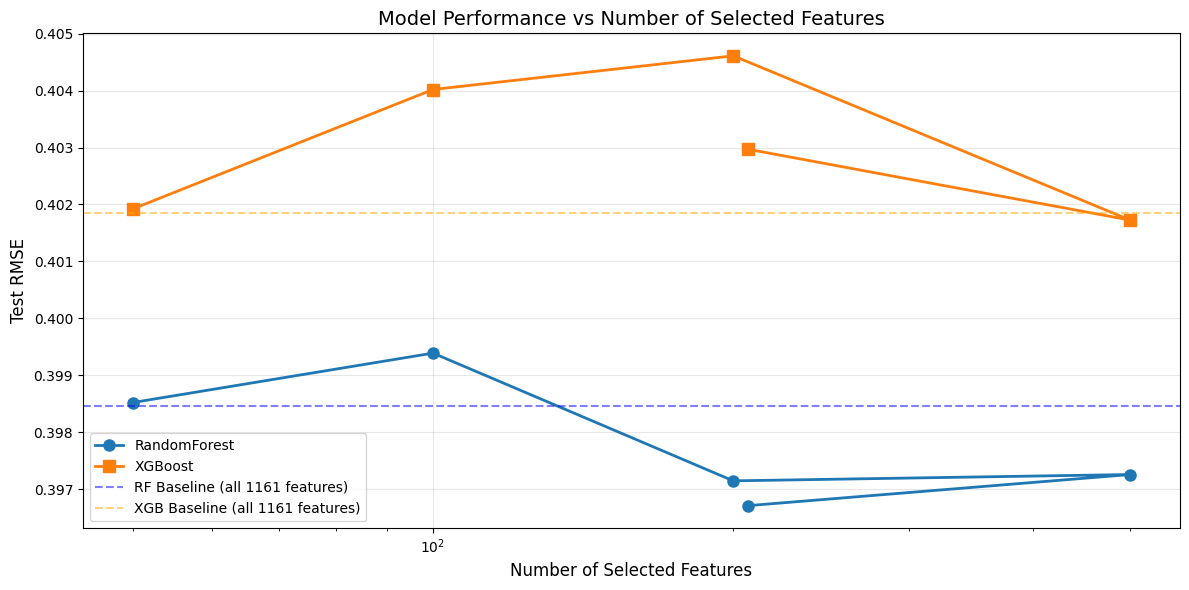


🏆 Best Feature Selection:
   RandomForest: 207 features, RMSE = 0.396711
   XGBoost: 500 features, RMSE = 0.401725

💾 Saved selection results to: feature_selection_results.csv


In [85]:
# Retrain models with selected features and compare performance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

print("🔄 Retraining with Selected Features")
print("="*60)

# Select top K features based on average importance
# Try different numbers of features
feature_counts = [50, 100, 200, 500, lasso_nonzero]

# Store results
selection_results = []

for k in feature_counts:
    if k > len(rf_importances):
        continue
    
    # Get top K feature indices
    top_k_indices = feature_df.head(k).index.values.astype(int)
    
    # Select features
    X_train_selected = X_train_scaled[:, top_k_indices]
    X_test_selected = X_test_scaled[:, top_k_indices]
    
    # Retrain RandomForest with selected features
    rf_selected = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
    rf_selected.fit(X_train_selected, y_train)
    rf_pred = rf_selected.predict(X_test_selected)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    
    # Retrain XGBoost with selected features (if available)
    if _has_xgb:
        xgb_selected = XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            objective='reg:squarederror',
            n_jobs=-1,
            random_state=42,
            tree_method='hist'
        )
        xgb_selected.fit(X_train_selected, y_train)
        xgb_pred = xgb_selected.predict(X_test_selected)
        xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
    else:
        xgb_rmse = None
    
    # Store results
    selection_results.append({
        'n_features': k,
        'RF_RMSE': rf_rmse,
        'XGB_RMSE': xgb_rmse,
        'feature_indices': top_k_indices[:20].tolist()  # Store first 20 for reference
    })
    
    print(f"\n📊 {k} Features Selected:")
    print(f"   RandomForest RMSE: {rf_rmse:.6f} (vs {np.sqrt(mean_squared_error(y_test, models['RandomForest(200)'].predict(X_test_scaled))):.6f} with all features)")
    if xgb_rmse is not None:
        print(f"   XGBoost RMSE: {xgb_rmse:.6f} (vs {np.sqrt(mean_squared_error(y_test, models['XGBRegressor'].predict(X_test_scaled))):.6f} with all features)")

# Create comparison plot
fig, ax = plt.subplots(figsize=(12, 6))

results_df = pd.DataFrame(selection_results)
x_pos = np.arange(len(results_df))

# Plot RMSE for different feature counts
ax.plot(results_df['n_features'], results_df['RF_RMSE'], 'o-', label='RandomForest', linewidth=2, markersize=8)
if _has_xgb and 'XGB_RMSE' in results_df.columns:
    ax.plot(results_df['n_features'], results_df['XGB_RMSE'], 's-', label='XGBoost', linewidth=2, markersize=8)

# Add baseline (all features)
baseline_rf = np.sqrt(mean_squared_error(y_test, models['RandomForest(200)'].predict(X_test_scaled)))
ax.axhline(y=baseline_rf, color='blue', linestyle='--', alpha=0.5, label=f'RF Baseline (all {len(rf_importances)} features)')

if _has_xgb:
    baseline_xgb = np.sqrt(mean_squared_error(y_test, models['XGBRegressor'].predict(X_test_scaled)))
    ax.axhline(y=baseline_xgb, color='orange', linestyle='--', alpha=0.5, label=f'XGB Baseline (all {len(rf_importances)} features)')

ax.set_xlabel('Number of Selected Features', fontsize=12)
ax.set_ylabel('Test RMSE', fontsize=12)
ax.set_title('Model Performance vs Number of Selected Features', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('feature_selection_performance.png', dpi=150, bbox_inches='tight')
print(f"\n💾 Saved performance comparison to: feature_selection_performance.png")
plt.show()

# Find optimal number of features
best_rf = results_df.loc[results_df['RF_RMSE'].idxmin()]
print(f"\n🏆 Best Feature Selection:")
print(f"   RandomForest: {int(best_rf['n_features'])} features, RMSE = {best_rf['RF_RMSE']:.6f}")

if _has_xgb:
    best_xgb = results_df.loc[results_df['XGB_RMSE'].idxmin()]
    print(f"   XGBoost: {int(best_xgb['n_features'])} features, RMSE = {best_xgb['XGB_RMSE']:.6f}")

# Save selection results
results_df.to_csv('feature_selection_results.csv', index=False)
print(f"\n💾 Saved selection results to: feature_selection_results.csv")


🔬 Feature Interpretation

📐 Feature Structure:
   Channels: 129
   Features per channel: 9
   Total features: 1161

🎯 Top 20 Most Important Features (Interpreted):
--------------------------------------------------------------------------------
Rank   Feature Index   Channel    Feature Type         RF Imp       XGB Imp      Avg Imp     
--------------------------------------------------------------------------------
1      932             103        theta_power          1.0000       1.0000       0.6667      
2      1043            115        gamma_power          0.9118       0.5722       0.4947      
3      599             66         theta_power          0.4307       0.5645       0.4576      
4      300             33         kurtosis             0.1624       0.1750       0.4458      
5      602             66         gamma_power          0.6070       0.7000       0.4356      
6      669             74         kurtosis             0.2852       0.1909       0.4226      
7      561      

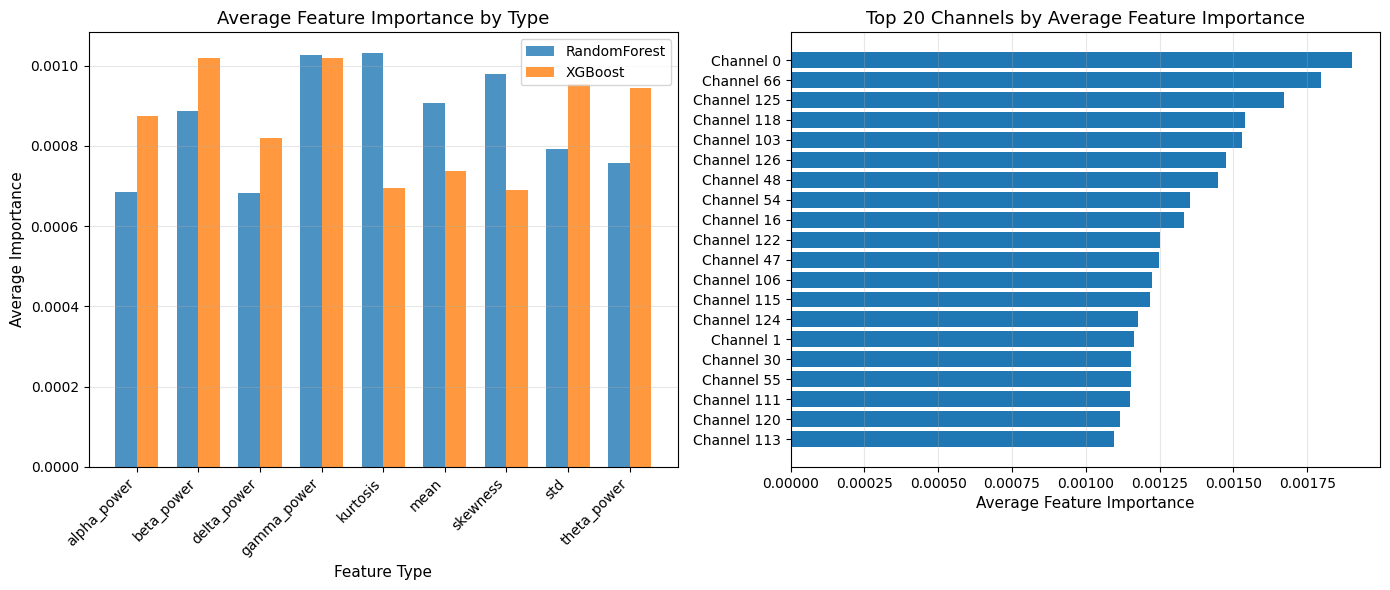


💾 Saved feature mapping to: feature_mapping.csv


In [87]:
# Understanding what the features represent
# Map feature indices back to their physical meaning
print("🔬 Feature Interpretation")
print("="*60)

# From extract_features_from_window, we know:
# - 129 channels
# - Features per channel: mean, std, skewness, kurtosis, and 5 bandpowers (delta, theta, alpha, beta, gamma)
# - Total: 4 stats + 5 bandpowers = 9 features per channel
# - 129 channels * 9 features = 1161 features

n_chans = 129
features_per_channel = 9  # mean, std, skew, kurt, 5 bandpowers
feature_names_per_channel = ['mean', 'std', 'skewness', 'kurtosis', 
                              'delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power']

print(f"\n📐 Feature Structure:")
print(f"   Channels: {n_chans}")
print(f"   Features per channel: {features_per_channel}")
print(f"   Total features: {n_chans * features_per_channel}")

# Create mapping from feature index to (channel, feature_type)
feature_mapping = {}
for feat_idx in range(len(rf_importances)):
    channel_idx = feat_idx // features_per_channel
    feature_type_idx = feat_idx % features_per_channel
    feature_type = feature_names_per_channel[feature_type_idx]
    feature_mapping[feat_idx] = {
        'channel': channel_idx,
        'feature_type': feature_type,
        'channel_feature_name': f'Channel_{channel_idx}_{feature_type}'
    }

# Analyze top features
print(f"\n🎯 Top 20 Most Important Features (Interpreted):")
print("-" * 80)
print(f"{'Rank':<6} {'Feature Index':<15} {'Channel':<10} {'Feature Type':<20} {'RF Imp':<12} {'XGB Imp':<12} {'Avg Imp':<12}")
print("-" * 80)

top_20 = feature_df.head(20)
for rank, (feat_idx, row) in enumerate(top_20.iterrows(), 1):
    info = feature_mapping[int(feat_idx)]
    rf_imp = f"{row['RandomForest']:.4f}"
    xgb_imp = f"{row['XGBoost']:.4f}" if xgb_importances is not None else "N/A"
    avg_imp = f"{row['Avg_Importance']:.4f}"
    
    print(f"{rank:<6} {int(feat_idx):<15} {info['channel']:<10} {info['feature_type']:<20} {rf_imp:<12} {xgb_imp:<12} {avg_imp:<12}")

# Analyze by feature type
print(f"\n📊 Feature Importance by Type:")
print("-" * 60)
feature_type_importance = {}

for feat_idx in range(len(rf_importances)):
    info = feature_mapping[feat_idx]
    feat_type = info['feature_type']
    
    if feat_type not in feature_type_importance:
        feature_type_importance[feat_type] = {
            'rf_sum': 0,
            'xgb_sum': 0,
            'count': 0
        }
    
    feature_type_importance[feat_type]['rf_sum'] += rf_importances[feat_idx]
    if xgb_importances is not None:
        feature_type_importance[feat_type]['xgb_sum'] += xgb_importances[feat_idx]
    feature_type_importance[feat_type]['count'] += 1

print(f"{'Feature Type':<20} {'RF Avg Imp':<15} {'XGB Avg Imp':<15} {'Count':<10}")
print("-" * 60)
for feat_type in sorted(feature_type_importance.keys()):
    data = feature_type_importance[feat_type]
    rf_avg = data['rf_sum'] / data['count']
    xgb_avg = data['xgb_sum'] / data['count'] if xgb_importances is not None else 0
    count = data['count']
    print(f"{feat_type:<20} {rf_avg:<15.6f} {xgb_avg:<15.6f} {count:<10}")

# Visualize feature importance by type
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot of average importance by feature type
types = sorted(feature_type_importance.keys())
rf_avgs = [feature_type_importance[t]['rf_sum'] / feature_type_importance[t]['count'] for t in types]
xgb_avgs = [feature_type_importance[t]['xgb_sum'] / feature_type_importance[t]['count'] if xgb_importances is not None else 0 
           for t in types]

x = np.arange(len(types))
width = 0.35

axes[0].bar(x - width/2, rf_avgs, width, label='RandomForest', alpha=0.8)
if xgb_importances is not None:
    axes[0].bar(x + width/2, xgb_avgs, width, label='XGBoost', alpha=0.8)

axes[0].set_xlabel('Feature Type', fontsize=11)
axes[0].set_ylabel('Average Importance', fontsize=11)
axes[0].set_title('Average Feature Importance by Type', fontsize=13)
axes[0].set_xticks(x)
axes[0].set_xticklabels(types, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Analyze by channel (which channels are most important overall)
print(f"\n📊 Top 10 Most Important Channels (by average feature importance):")
print("-" * 60)

channel_importance = {}
for feat_idx in range(len(rf_importances)):
    info = feature_mapping[feat_idx]
    channel = info['channel']
    
    if channel not in channel_importance:
        channel_importance[channel] = []
    
    channel_importance[channel].append(rf_importances[feat_idx])

channel_avg_importance = {ch: np.mean(imps) for ch, imps in channel_importance.items()}
top_channels = sorted(channel_avg_importance.items(), key=lambda x: x[1], reverse=True)[:10]

print(f"{'Rank':<6} {'Channel':<10} {'Avg Importance':<15}")
print("-" * 60)
for rank, (channel, avg_imp) in enumerate(top_channels, 1):
    print(f"{rank:<6} {channel:<10} {avg_imp:<15.6f}")

# Visualize channel importance
top_20_channels = sorted(channel_avg_importance.items(), key=lambda x: x[1], reverse=True)[:20]
channels_sorted = [ch for ch, _ in top_20_channels]
importances_sorted = [imp for _, imp in top_20_channels]

axes[1].barh(range(len(channels_sorted)), importances_sorted)
axes[1].set_yticks(range(len(channels_sorted)))
axes[1].set_yticklabels([f'Channel {ch}' for ch in channels_sorted])
axes[1].set_xlabel('Average Feature Importance', fontsize=11)
axes[1].set_title('Top 20 Channels by Average Feature Importance', fontsize=13)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_interpretation.png', dpi=150, bbox_inches='tight')
print(f"\n💾 Saved interpretation analysis to: feature_interpretation.png")
plt.show()

# Save detailed mapping
mapping_df = pd.DataFrame(feature_mapping).T
mapping_df['RF_Importance'] = rf_importances
if xgb_importances is not None:
    mapping_df['XGB_Importance'] = xgb_importances
mapping_df['Lasso_Coefficient'] = lasso_coef
mapping_df.to_csv('feature_mapping.csv')
print(f"\n💾 Saved feature mapping to: feature_mapping.csv")


In [ ]:
# # Save Model as .pt File
# import os
# from datetime import datetime

# def save_model_as_pt(model, save_dir="models", filename=None):
#     """
#     Save EEGConformer model as .pt file (PyTorch format)
#     """
#     # Create save directory if it doesn't exist
#     os.makedirs(save_dir, exist_ok=True)
    
#     if filename is None:
#         timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#         filename = f"eegconformer_challenge1_{timestamp}.pt"
    
#     model_path = os.path.join(save_dir, filename)
    
#     # Save only the model state dict (standard .pt format)
#     torch.save(model.state_dict(), model_path)
    
#     print(f"✅ Model saved as .pt file: {model_path}")
#     print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
#     print(f"   File size: {os.path.getsize(model_path) / 1024 / 1024:.2f} MB")
    
#     return model_path

# def load_model_from_pt(model_path, device):
#     """
#     Load EEGConformer model from .pt file
#     """
#     # Model configuration (must match training configuration)
#     model_config = {
#         'n_chans': 129,
#         'n_outputs': 1,
#         'n_times': 200,
#         'sfreq': 100,
#         'n_filters_time': 40,
#         'filter_time_length': 25,
#         'pool_time_length': 75,
#         'pool_time_stride': 15,
#         'att_depth': 6,
#         'att_heads': 10,
#         'drop_prob': 0.5,
#         'att_drop_prob': 0.5,
#         'final_fc_length': 'auto',
#         'return_features': False,
#         'activation': torch.nn.ELU,
#         'activation_transfor': torch.nn.GELU,
#     }
    
#     # Create model with same configuration
#     model = EEGConformer(**model_config)
    
#     # Load state dict
#     model.load_state_dict(torch.load(model_path, map_location=device))
#     model.to(device)
#     model.eval()  # Set to evaluation mode
    
#     print(f"✅ Model loaded from .pt file: {model_path}")
#     print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
#     return model

# # Example usage:
# # Save model after training:
# # model_path = save_model_as_pt(model_conformer, filename="my_eegconformer.pt")

# # Load model for inference:
# # loaded_model = load_model_from_pt(model_path, device)

# print("💾 Model Saving/Loading Ready!")
# print("Use save_model_as_pt() to save as .pt file")
# print("Use load_model_from_pt() to load from .pt file")


💾 Model Saving/Loading Ready!
Use save_model_as_pt() to save as .pt file
Use load_model_from_pt() to load from .pt file
